In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Activation, concatenate, Conv2D, Conv2DTranspose,
                                     MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from PIL import Image

from sklearn.model_selection import train_test_split

from google.colab import files

%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Параметры
img_width, img_height, channels = 176, 320, 3
img_size = img_width, img_height, channels
Path = '/content/drive/MyDrive/UAI/Data_CSV/Airplanes_set/'
num_classes = 2


In [8]:
# Загружаем изображения самолетов
airplanes = []
start_timeA = time.time()
for file_name in sorted(os.listdir(Path + 'airplanes')):
    airplanes.append(image.load_img(os.path.join(Path + 'airplanes', file_name), 
                                    target_size=(img_size)))
print(f'Время загрузки airplanes: {(time.time() - start_timeA):.4f} c')


Время загрузки airplanes: 169.3671 c


In [9]:
# Загружаем изображения сегментированных изображений самолетов
airplanes_segment = []
start_timeS = time.time()
for file_name in sorted(os.listdir(Path + 'airplanes_segment')):
    airplanes_segment.append(image.load_img(os.path.join(Path + 'airplanes_segment', file_name), 
                                                         target_size=(img_size)))
print(f'Время загрузки airplanes_segment: {(time.time() - start_timeS):.4f} c',sep='')


Время загрузки airplanes_segment: 786.8268 c


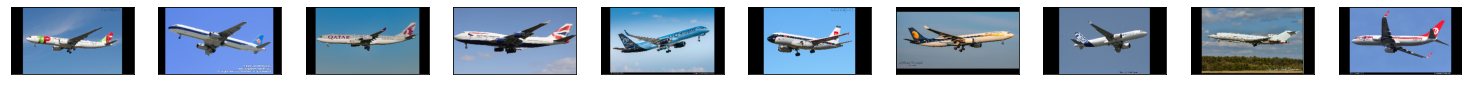

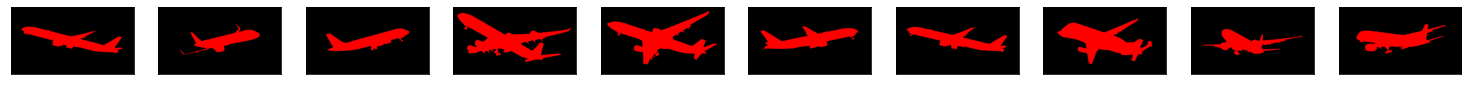

In [10]:
# Выводим оригиналы самолетов и сегментов самолетов
plt.figure(figsize=(26, 12))
for i in range(10):
    img = random.choice(airplanes)
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

plt.figure(figsize=(26, 12))
for i in range(10):
    img_segment = random.choice(airplanes_segment)
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_segment)
    
plt.show()


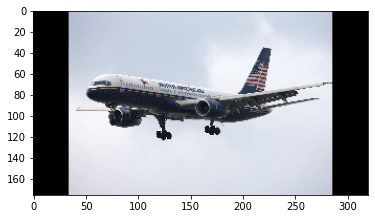

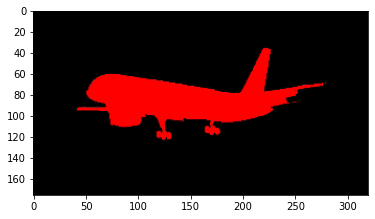

In [11]:
# Вывод одиночного изобрвжения и его сегмента
plt.imshow(airplanes[111])
plt.show()

plt.imshow(airplanes_segment[111])
plt.show()


In [12]:
# Преобразовываем пиксели сегментированного изображения в индекс
def color_to_index(color):
    index = 0
    if(color[0] + color[1] + color[2]) > 20:
        index =  1
    
    return index


In [13]:
# Индексы: цвет фона, цвет самолета
def index_to_color(index_2):
    index = np.argmax(index_2)
    color = []
    if index == 0:
        color = [0, 0, 0]
    elif index == 1:
        color = [255, 0, 0]

    return color


In [23]:
def index_to_Y(y, num_classes):
    y_shape = y.shape
    y = y.reshape(y.shape[0] * y.shape[1], 3)
    yi = []
    for i in range(len(y)):
        yi.append(to_categorical(color_to_index(y[i]), num_classes=num_classes))
    yi = np.array(yi)
    yi = yi.reshape(y_shape[0], y_shape[1], num_classes)
    return yi

In [24]:
# Создаем Y
def Y(airplanes_segment, num_classes):
    Y = []
    for segment in airplanes_segment:
        y = image.img_to_array(segment)
        y = index_to_Y(y, num_classes)
        Y.append(y)
    Y = np.array(Y)
    
    return Y

Y = Y(airplanes_segment, num_classes)  

In [25]:
# Создаем X
X = []
for airplane in airplanes:
    plane = image.img_to_array(airplane)
    X.append(plane)
X = np.array(X)
X.shape


(1000, 176, 320, 3)

In [26]:
#Y = Y(airplanes_segment, num_classes)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [28]:
# Intersection Of Two Regions
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [29]:
# PSP-Net
input = Input((img_size))

# Entrance
entr = Conv2D(32, 3, padding='same', activation='relu', name='entr_conv1')(input)
entr = Conv2D(32, 3,padding='same', activation='relu', name='entr_conv2')(entr)

# Piramid
piramid_1 = MaxPooling2D(2)(entr)
piramid_2 = MaxPooling2D(4)(entr)
piramid_3 = MaxPooling2D(8)(entr)
piramid_4 = MaxPooling2D(16)(entr)

# Conv Layers
conv_1 = Conv2D(64, 3, padding='same', activation='relu', name='conv_conv1')(piramid_1)
conv_2 = Conv2D(64, 3, padding='same', activation='relu', name='conv_conv2')(piramid_2)
conv_3 = Conv2D(64, 3, padding='same', activation='relu', name='conv_conv3')(piramid_3)
conv_4 = Conv2D(64, 3, padding='same', activation='relu', name='conv_conv4')(piramid_4)

# Increase size 

incr_1 = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(conv_1)
incr_2 = Conv2DTranspose(64, 3, strides=4, padding='same', activation='relu')(conv_2)
incr_3 = Conv2DTranspose(64, 3, strides=8, padding='same', activation='relu')(conv_3)
incr_4 = Conv2DTranspose(64, 3, strides=16, padding='same', activation='relu')(conv_4)

# Concatenate layers
out = concatenate([incr_1, incr_2, incr_3, incr_4])

# Out
out_psp = Conv2D(num_classes, 3, padding='same', activation='softmax')(out)


In [30]:
model_psp = Model(input, out_psp)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 176, 320, 3) 0                                            
__________________________________________________________________________________________________
entr_conv1 (Conv2D)             (None, 176, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
entr_conv2 (Conv2D)             (None, 176, 320, 32) 9248        entr_conv1[0][0]                 
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 88, 160, 32)  0           entr_conv2[0][0]                 
______________________________________________________________________________________________

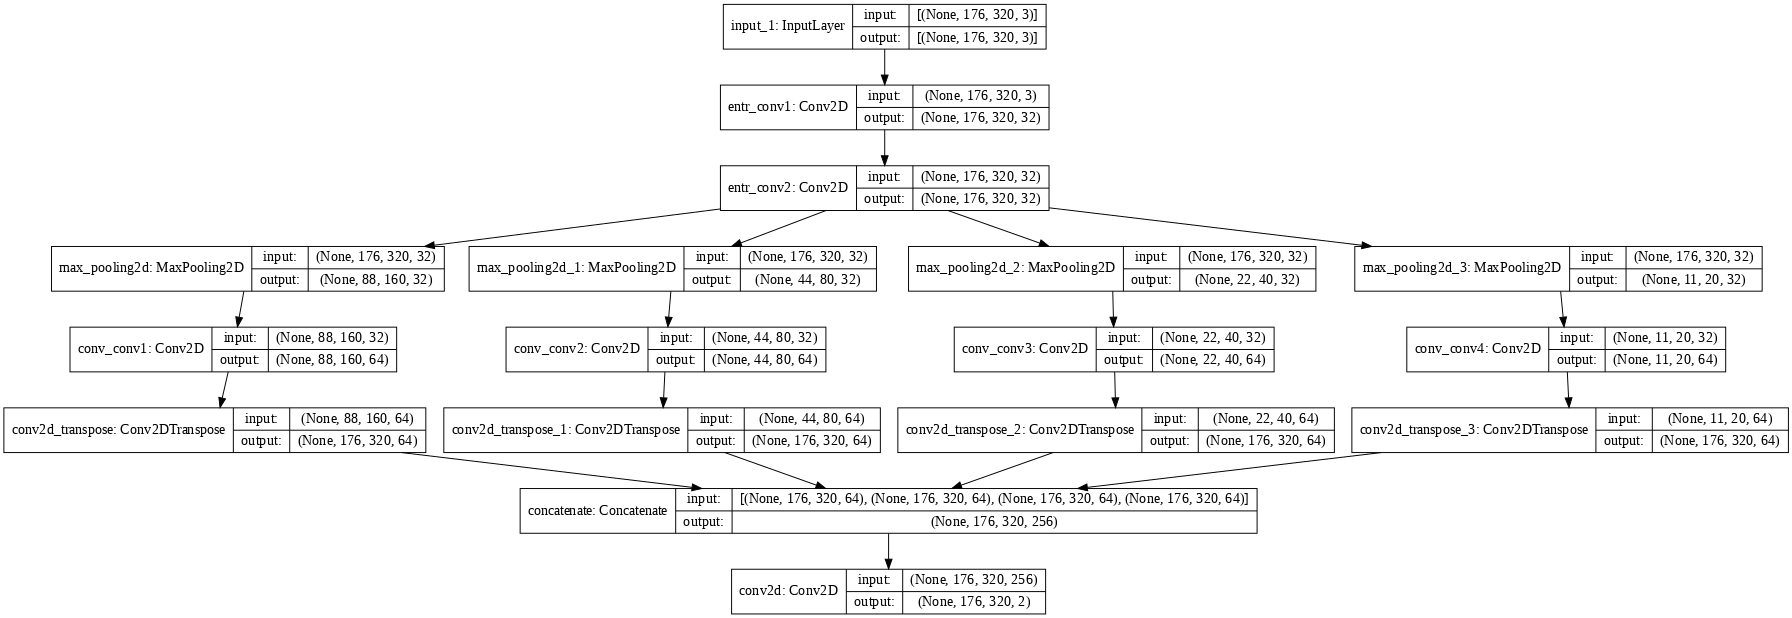

In [31]:
model_psp.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])
model_psp.summary()
plot_model(model_psp, dpi=70, show_shapes=True)

In [32]:
history_psp = model_psp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
29/29 [==============================] - 68s 1s/step - loss: 1.6135 - dice_coef: 0.7043 - val_loss: 0.5224 - val_dice_coef: 0.7756
Epoch 2/50
29/29 [==============================] - 30s 1s/step - loss: 0.3819 - dice_coef: 0.8029 - val_loss: 0.2763 - val_dice_coef: 0.8343
Epoch 3/50
29/29 [==============================] - 30s 1s/step - loss: 0.2665 - dice_coef: 0.8466 - val_loss: 0.2221 - val_dice_coef: 0.8620
Epoch 4/50
29/29 [==============================] - 30s 1s/step - loss: 0.2317 - dice_coef: 0.8638 - val_loss: 0.1998 - val_dice_coef: 0.8768
Epoch 5/50
29/29 [==============================] - 30s 1s/step - loss: 0.2104 - dice_coef: 0.8765 - val_loss: 0.1901 - val_dice_coef: 0.8853
Epoch 6/50
29/29 [==============================] - 30s 1s/step - loss: 0.1968 - dice_coef: 0.8834 - val_loss: 0.1759 - val_dice_coef: 0.8924
Epoch 7/50
29/29 [==============================] - 30s 1s/step - loss: 0.1860 - dice_coef: 0.8903 - val_loss: 0.1665 - val_dice_coef: 0.8966
Epoch 

In [56]:
print(f' Пересечение на Обучении: {100 * max(history_psp.history["dice_coef"]):.4f} %\
\n Пересечение на Проверке: {100 * max(history_psp.history["val_dice_coef"]):.4f} %')

 Пересечение на Обучении: 95.7947 %
 Пересечение на Проверке: 96.5818 %


In [ ]:
# График ошибок
plt.figure(figsize=(16,8))
plt.plot(history_bot.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history_bot.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.title('График ошибок', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Средняя ошибка', fontsize=12)
plt.legend()
plt.show()

In [34]:
 #model_psp.save_weights('/content/drive/MyDrive/UAI/save_nets/model_psp.h5')

In [33]:
#model_psp = Model(input, out_psp)
#model_psp.load_weights('/content/drive/MyDrive/UAI/save_nets/model_psp.h5')

IPython will make a temporary file named: /tmp/ipython_edit_tek7pzti/ipython_edit__k8nyvz7.py


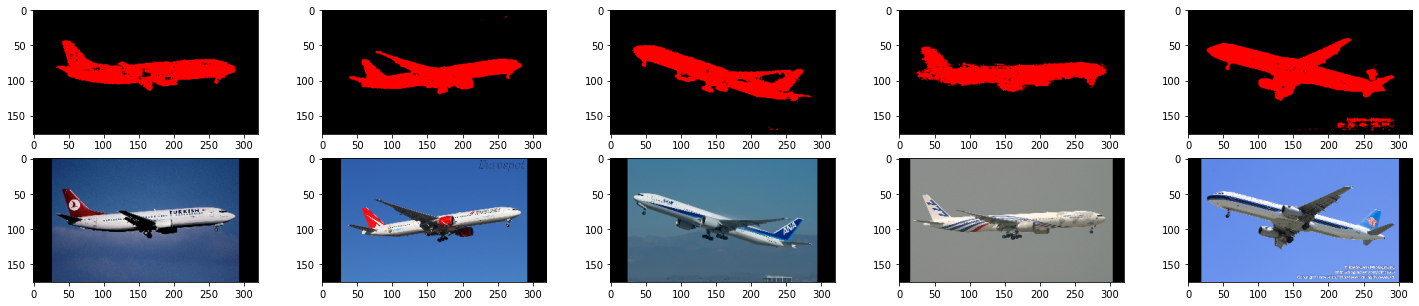

In [57]:
# Выведем распознанные сегментированные изображения
n = 5
#n_classes = 2
indexes = np.random.randint(0, len(X_test), n)
fig, axs = plt.subplots(2, n, figsize=(25, 5))
for i, idx in enumerate(indexes):
    predict = np.array(model_psp.predict(X_test[idx].reshape(1, img_width, img_height, channels)))
    pred = predict[0]
    pred_s = []
    pred = pred.reshape(-1, num_classes)
    for k in range(len(pred)):
        pred_s.append(index_to_color(pred[k]))
    pred_s = np.array(pred_s)
    pred_s = pred_s.reshape(img_width, img_height, channels)
    img = Image.fromarray(pred_s.astype('uint8'))
    axs[0,i].imshow(img.convert('RGBA'))
    axs[1,i].imshow(Image.fromarray(X_test[idx].astype('uint8')))        

plt.show() 

Наложим маску

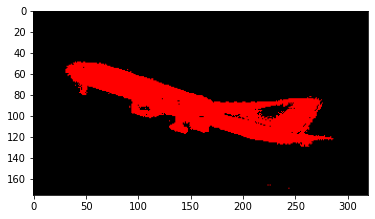

In [80]:
segment = Image.fromarray(pred_s.astype('uint8')).convert('RGBA')
plt.imshow(segment)

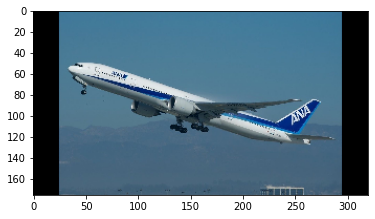

In [77]:
plt.imshow(Image.fromarray(X_test[idx].astype('uint8')))

In [78]:
mask = np.array(segment)
mask[mask[:,:,0] <= 20] = [0, 0, 0, 0]
mask[mask[:,:,0] > 20] = [0, 150, 0, 150]

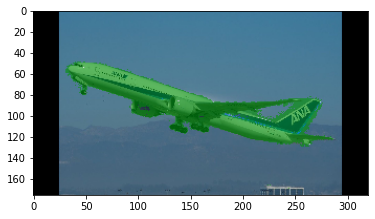

In [79]:
img = Image.fromarray(X_test[idx].astype('uint8'))
img_2 = Image.fromarray(mask).convert('RGBA')
img.paste(img_2, (0, 0),img_2)
plt.imshow(img)

PSP-Net 2

In [40]:
# PSP-Net 2
input = Input((img_size))

# Entrance
entr = Conv2D(32, 3, padding='same', activation='relu', name='entr_conv1')(input)
entr = Conv2D(32, 3,padding='same', activation='relu', name='entr_conv2')(entr)
###
entr_mask = Conv2D(32, 1, padding='same')(entr)

# Piramid
piramid_1 = MaxPooling2D(2)(entr)
piramid_2 = MaxPooling2D(4)(entr)
piramid_3 = MaxPooling2D(8)(entr)
piramid_4 = MaxPooling2D(16)(entr)

# Conv Layers
conv_1 = Conv2D(64, 3, padding='same', activation='relu', name='conv_conv1')(piramid_1)
conv_2 = Conv2D(64, 3, padding='same', activation='relu', name='conv_conv2')(piramid_2)
conv_3 = Conv2D(64, 3, padding='same', activation='relu', name='conv_conv3')(piramid_3)
conv_4 = Conv2D(64, 3, padding='same', activation='relu', name='conv_conv4')(piramid_4)

# Increase size 
incr_1 = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(conv_1)
incr_2 = Conv2DTranspose(64, 3, strides=4, padding='same', activation='relu')(conv_2)
incr_3 = Conv2DTranspose(64, 3, strides=8, padding='same', activation='relu')(conv_3)
incr_4 = Conv2DTranspose(64, 3, strides=16, padding='same', activation='relu')(conv_4)


# Concatenate layers
out = concatenate([entr_mask,incr_1, incr_2, incr_3, incr_4])

# Out
out_psp2 = Conv2D(num_classes, 3, padding='same', activation='softmax')(out)


In [41]:
model_psp2 = Model(input, out_psp2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 176, 320, 3) 0                                            
__________________________________________________________________________________________________
entr_conv1 (Conv2D)             (None, 176, 320, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
entr_conv2 (Conv2D)             (None, 176, 320, 32) 9248        entr_conv1[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 88, 160, 32)  0           entr_conv2[0][0]                 
____________________________________________________________________________________________

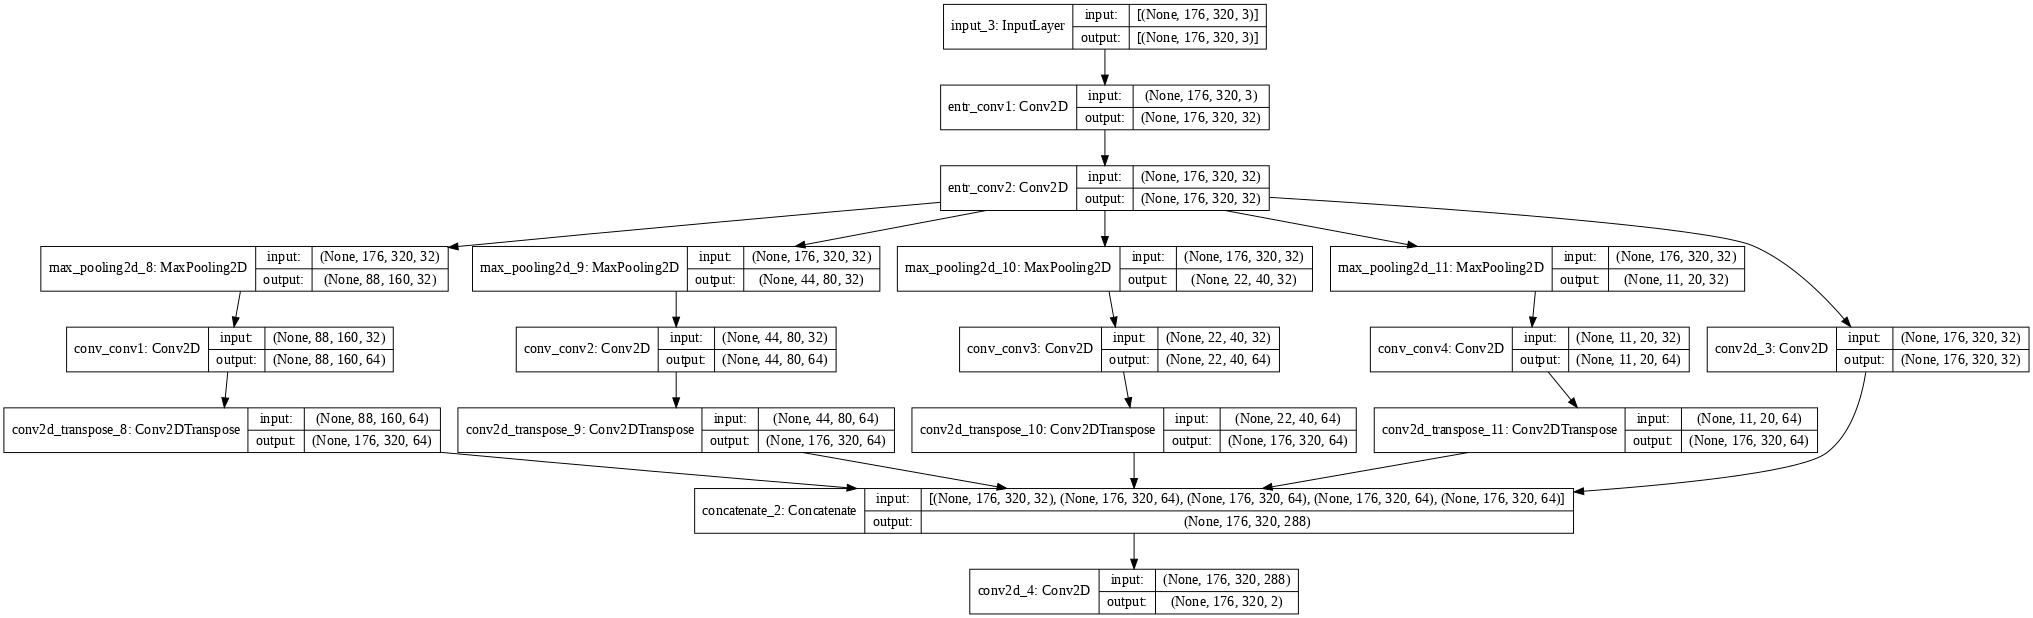

In [42]:
model_psp2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])
model_psp2.summary()
plot_model(model_psp2, dpi=70, show_shapes=True)

In [43]:
history_psp2 = model_psp2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
29/29 [==============================] - 39s 1s/step - loss: 1.8808 - dice_coef: 0.7317 - val_loss: 0.5116 - val_dice_coef: 0.7673
Epoch 2/50
29/29 [==============================] - 34s 1s/step - loss: 0.4750 - dice_coef: 0.8130 - val_loss: 0.3224 - val_dice_coef: 0.8387
Epoch 3/50
29/29 [==============================] - 34s 1s/step - loss: 0.3114 - dice_coef: 0.8463 - val_loss: 0.2521 - val_dice_coef: 0.8613
Epoch 4/50
29/29 [==============================] - 34s 1s/step - loss: 0.2578 - dice_coef: 0.8629 - val_loss: 0.2156 - val_dice_coef: 0.8793
Epoch 5/50
29/29 [==============================] - 34s 1s/step - loss: 0.2276 - dice_coef: 0.8774 - val_loss: 0.1960 - val_dice_coef: 0.8899
Epoch 6/50
29/29 [==============================] - 34s 1s/step - loss: 0.2094 - dice_coef: 0.8873 - val_loss: 0.1794 - val_dice_coef: 0.8956
Epoch 7/50
29/29 [==============================] - 34s 1s/step - loss: 0.1958 - dice_coef: 0.8932 - val_loss: 0.1699 - val_dice_coef: 0.9019
Epoch 

In [62]:
print(f' Пересечение на Обучении: {100 * max(history_psp2.history["dice_coef"]):.4f} %\
\n Пересечение на Проверке: {100 * max(history_psp2.history["val_dice_coef"]):.4f} %')

 Пересечение на Обучении: 95.8934 %
 Пересечение на Проверке: 96.5471 %


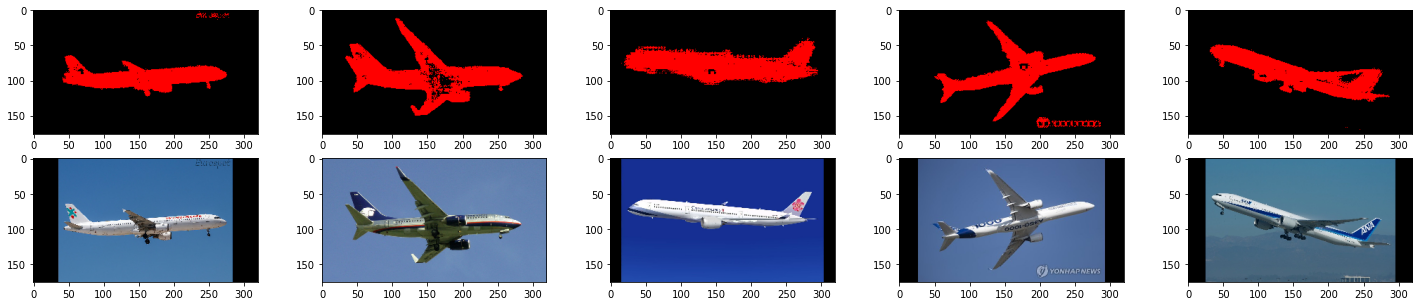

In [64]:
# Выведем распознанные сегментированные изображения PSP-Net 2
n = 5
#n_classes = 2
indexes = np.random.randint(0, len(X_test), n)
fig, axs = plt.subplots(2, n, figsize=(25, 5))
for i, idx in enumerate(indexes):
    predict = np.array(model_psp2.predict(X_test[idx].reshape(1, img_width, img_height, channels)))
    pred = predict[0]
    pred_s = []
    pred = pred.reshape(-1, num_classes)
    for k in range(len(pred)):
        pred_s.append(index_to_color(pred[k]))
    pred_s = np.array(pred_s)
    pred_s = pred_s.reshape(img_width, img_height, channels)
    img = Image.fromarray(pred_s.astype('uint8'))
    axs[0,i].imshow(img.convert('RGBA'))
    axs[1,i].imshow(Image.fromarray(X_test[idx].astype('uint8')))        

plt.show()

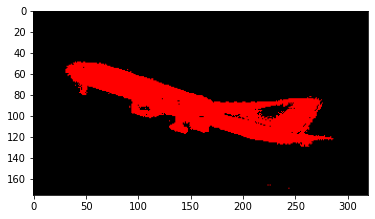

In [65]:
segment2 = Image.fromarray(pred_s.astype('uint8')).convert('RGBA')
plt.imshow(segment2)
plt.show()

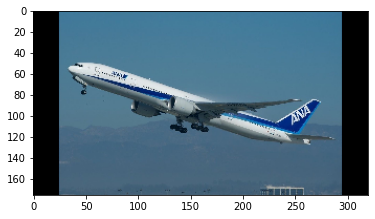

In [66]:
plt.imshow(Image.fromarray(X_test[idx].astype('uint8')))
plt.show()

In [71]:
mask2 = np.array(segment2)
mask2[mask2[:,:,0] <= 20] = [0, 0, 0, 0]
mask2[mask2[:,:,0] > 20] = [0, 150, 0, 150]

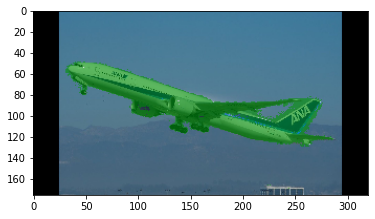

In [74]:
img = Image.fromarray(X_test[idx].astype('uint8'))
img_2 = Image.fromarray(mask2).convert('RGBA')
img.paste(img_2, (0, 0),img_2)
plt.imshow(img)
plt.show()

In [63]:
# сравниваем PSP-Net и PSP-Net2
print(f' Пересечение на Проверке PSP-Net: {100 * max(history_psp.history["val_dice_coef"]):.4f} %\
\n Пересечение на Проверке PSP-Net2 : {100 * max(history_psp2.history["val_dice_coef"]):.4f} %')

 Пересечение на Проверке PSP-Net: 96.5818 %
 Пересечение на Проверке PSP-Net2 : 96.5471 %


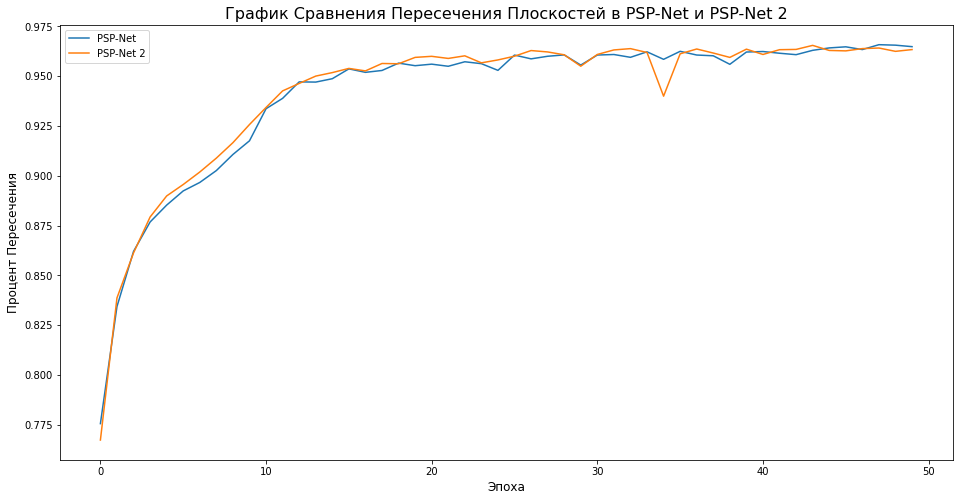

In [83]:
# График Сравнения Пересечения плоскостей в PSP-Net и PSP-Net 2
plt.figure(figsize=(16,8))
plt.plot(history_psp.history['val_dice_coef'], label='PSP-Net')
plt.plot(history_psp2.history['val_dice_coef'], label='PSP-Net 2')
plt.title('График Сравнения Пересечения Плоскостей в PSP-Net и PSP-Net 2', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Процент Пересечения', fontsize=12)
plt.legend()
plt.show()